In [1]:
import os
import pandas as pd
import ast
import numpy as np

import librosa

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
import pickle

In [2]:
# path to the small directory
SMALL_AUDIO_DIR = '../data/fma_small/'

# function to get the paths to all the songs in the small dataset
def audio_paths(AUDIO_DIR):
    AUDIO_PATHS = []
    # iterate through all the directories with songs in them
    for path in [os.path.join('../data/fma_small/', p) 
                 for p in os.listdir('../data/fma_small/') 
                 if not (p.endswith('checksums') or p.endswith('.txt') or p.endswith('.DS_Store'))]:
        # add all songs to the list
        AUDIO_PATHS = AUDIO_PATHS + [os.path.join(path, track).replace('\\', '/') for track in os.listdir(path)]
    
    return AUDIO_PATHS

# store all the small paths
SMALL_PATHS = audio_paths(SMALL_AUDIO_DIR)

# function to load metadata
# adapted from https://github.com/mdeff/fma/blob/master/utils.py
def metadata_load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    pd.CategoricalDtype(categories=SUBSETS, ordered=True))
        except ValueError:
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks
    
# function to get genre information for each track ID
def track_genre_information(GENRE_PATH, TRACKS_PATH, FILE_PATHS, subset):
    """
    GENRE_PATH (str): path to the csv with the genre metadata
    TRACKS_PATH (str): path to the csv with the track metadata
    FILE_PATHS (list): list of paths to the mp3 files
    subset (str): the subset of the data desired
    """
    # get the genre information
    genres = pd.read_csv(GENRE_PATH)

    # load metadata on all the tracks
    tracks = metadata_load(TRACKS_PATH)

    # focus on the specific subset tracks
    subset_tracks = tracks[tracks['set', 'subset'] <= subset]

    # extract track ID and genre information for each track
    subset_tracks_genre = np.array([np.array(subset_tracks.index), 
                                  np.array(subset_tracks['track', 'genre_top'])]).T
    
    # extract track indices from the file paths
    track_indices = []
    for path in FILE_PATHS:
        track_indices.append(path.split('/')[-1].split('.')[0].lstrip('0'))

    # get the genre associated with each file path, thanks to the path ID
    track_indices = pd.DataFrame({'file_path':FILE_PATHS,'track_id':np.array(track_indices).astype(int)})
    tracks_genre_df = pd.DataFrame({'track_id': subset_tracks_genre[:,0], 'genre': subset_tracks_genre[:,1]})
    track_genre_data = track_indices.merge(tracks_genre_df, how='left')
    
    # label classes with numbers
    encoder = LabelEncoder()
    track_genre_data['genre_nb'] = encoder.fit_transform(track_genre_data.genre)
    
    return track_genre_data

# get genre information for all tracks from the small subset
GENRE_PATH = '../data/fma_metadata/genres.csv'
TRACKS_PATH = '../data/fma_metadata/tracks.csv'
subset = 'small'

small_tracks_genre = track_genre_information(GENRE_PATH, TRACKS_PATH, SMALL_PATHS, subset)

# split these paths and associated genres into training and test sets
SMALL_AUDIO_TRAIN, SMALL_AUDIO_TEST = train_test_split(SMALL_PATHS, test_size=0.2, random_state=42)

df_train = small_tracks_genre[small_tracks_genre.file_path.isin(SMALL_AUDIO_TRAIN)]
df_test = small_tracks_genre[small_tracks_genre.file_path.isin(SMALL_AUDIO_TEST)]

In [3]:
CONVERTED_TRAIN_PATH = '../data/pickle/train/'
CONVERTED_TEST_PATH = '../data/pickle/test/'

mfcc = pickle.load( open( CONVERTED_TRAIN_PATH + "mfcc.p", "rb" ) )
zcr = pickle.load( open( CONVERTED_TRAIN_PATH + "zcr.p", "rb" ) )
chroma_stft = pickle.load( open( CONVERTED_TRAIN_PATH + "chroma_stft.p", "rb" ) )
spectral_centroid = pickle.load( open( CONVERTED_TRAIN_PATH + "spectral_centroid.p", "rb" ) )
spectral_rolloff = pickle.load( open( CONVERTED_TRAIN_PATH + "spectral_rolloff.p", "rb" ) )

mfcc_test = pickle.load( open( CONVERTED_TEST_PATH + "mfcc.p", "rb" ) )
zcr_test = pickle.load( open( CONVERTED_TEST_PATH + "zcr.p", "rb" ) )
chroma_stft_test = pickle.load( open( CONVERTED_TEST_PATH + "chroma_stft.p", "rb" ) )
spectral_centroid_test = pickle.load( open( CONVERTED_TEST_PATH + "spectral_centroid.p", "rb" ) )
spectral_rolloff_test = pickle.load( open( CONVERTED_TEST_PATH + "spectral_rolloff.p", "rb" ) )

In [4]:
def preprocess_data(df, feature):
    df = df[df.file_path.isin(dict(feature).keys())]
    cleaned_feature_dict = defaultdict(np.array)
    for path in df.file_path.values:
        feature_result = dict(feature)[path]
        _, n_frames = feature_result.shape
        if n_frames < 2500: ## Remove all shorter mp3 files from analysis
            continue
        feature_result_fixed = feature_result[:, :2582] ## Resizes all np.arrays to 2582 frames
        cleaned_feature_dict[path] = feature_result_fixed
    df = df[df.file_path.isin(dict(cleaned_feature_dict).keys())]
    return df, cleaned_feature_dict

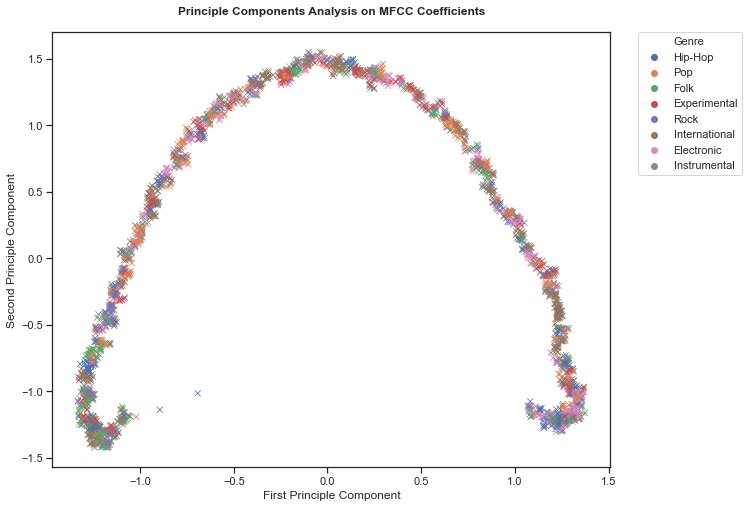

In [68]:
#PARAMETERS
df = df_train
feature = mfcc

df, feature = preprocess_data(df, feature)
y = df.genre.values
le = LabelEncoder()
y_transformed = le.fit_transform(y)

stacked_results = []
for path, genre in zip(df.file_path.values, y_transformed):
    feature_result = dict(feature)[path]
    scale = StandardScaler()
    scaled_feature_result = scale.fit_transform(feature_result)
    stacked_results.append(scaled_feature_result)
X = np.vstack(stacked_results)
y_transformed = np.repeat(y_transformed, 20)

pca = PCA(n_components=2, whiten=True)
X_transformed = pca.fit_transform(X.T)

sns.set(rc={'figure.figsize':(10, 8)})
sns.set_style("white")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

df_plot = pd.DataFrame(X_transformed, columns=["x", "y"])
temp_df = pd.DataFrame(y, columns=['Genre'])
df_plot['Genre'] = temp_df
ax = sns.scatterplot(x="x", y="y", hue='Genre', marker="x", data=df_plot)
ax.set_title('Principle Components Analysis on MFCC Coefficients\n', weight='bold')
plt.xlabel('First Principle Component')
plt.ylabel('Second Principle Component')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.savefig('problem2c.png')
plt.show()

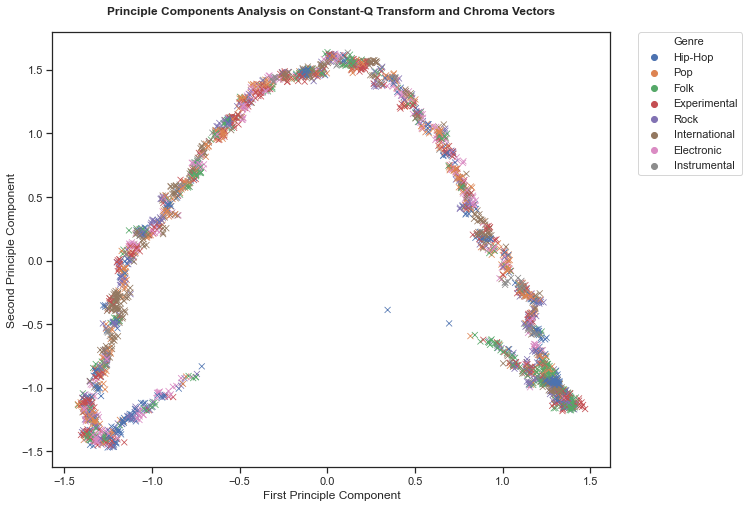

In [69]:
#PARAMETERS
df = df_train
feature = chroma_stft

df, feature = preprocess_data(df, feature)
y = df.genre.values
le = LabelEncoder()
y_transformed = le.fit_transform(y)

stacked_results = []
for path, genre in zip(df.file_path.values, y_transformed):
    feature_result = dict(feature)[path]
    scale = StandardScaler()
    scaled_feature_result = scale.fit_transform(feature_result)
    stacked_results.append(scaled_feature_result)
X = np.vstack(stacked_results)
y_transformed = np.repeat(y_transformed, 12)

pca = PCA(n_components=2, whiten=True)
X_transformed = pca.fit_transform(X.T)

sns.set(rc={'figure.figsize':(10, 8)})
sns.set_style("white")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

df_plot = pd.DataFrame(X_transformed, columns=["x", "y"])
temp_df = pd.DataFrame(y, columns=['Genre'])
df_plot['Genre'] = temp_df
ax = sns.scatterplot(x="x", y="y", hue='Genre', marker="x", data=df_plot)
ax.set_title('Principle Components Analysis on Constant-Q Transform and Chroma Vectors\n', weight='bold')
plt.xlabel('First Principle Component')
plt.ylabel('Second Principle Component')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.savefig('problem2c.png')
plt.show()

In [70]:
df = df_train
feature = zcr

df, feature = preprocess_data(df, feature)
y = df.genre.values
le = LabelEncoder()
y_transformed = le.fit_transform(y)

In [90]:
X_transformed = np.vstack(list(feature.values()))

In [87]:
y_transformed

array([3, 3, 6, ..., 6, 6, 3])